In [1]:
!pip install dremio-simple-query

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [dremio-simple-query]emio-simple-query]


## Get Dremio Access Token

In [5]:
from dremio_simple_query.connect import get_token
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Get credentials from environment
DREMIO_USER = os.getenv("DREMIO_USER")
DREMIO_PASSWORD = os.getenv("DREMIO_PASSWORD")

# URL to Login Endpoint
login_endpoint = "http://localhost:9047/apiv2/login"

# Payload for Login
payload = {
    "userName": DREMIO_USER,
    "password": DREMIO_PASSWORD
}

# Get token from API
token = get_token(login_endpoint, payload)

In [6]:
from pyarrow import flight
import pandas as pd

# Connect to Dremio Flight Server
client = flight.connect("grpc+tcp://localhost:32010")

# Authenticate with the token
headers = [
    (b'authorization', f'Bearer {token}'.encode('utf-8')),
]

# Query to get all products reviews
sql = "SELECT * FROM catalog.bronze.ecoride.product_reviews"

# Create a get all product reviews
descriptor = flight.FlightDescriptor.for_command(sql)

# Perform the query using call_options to include headers
options = flight.FlightCallOptions(headers=headers)
flight_info = client.get_flight_info(descriptor, options)
reader = client.do_get(flight_info.endpoints[0].ticket, options)

# Convert to Pandas DataFrame
product_reviews = reader.read_pandas()

# Display the first few rows of the DataFrame
print(product_reviews.head())

  CustomerID        Date  Rating ReviewID  \
0       1966  2021-03-16       4  REV2069   
1       2331  2023-05-26       4  REV7911   
2        445  2022-10-11       5  REV4626   
3       2019  2022-07-15       4  REV1804   
4       2174  2020-09-12       5  REV1565   

                                          ReviewText VehicleModel  
0  "We recently purchased the AeroFlow, and it's ...     AeroFlow  
1  Title: Balanced Review of the UrbanGlide EV\n\...   UrbanGlide  
2  I recently purchased the PowerRide EV, and I m...    PowerRide  
3  The UrbanGlide electric vehicle offers a sleek...   UrbanGlide  
4  I recently purchased the PowerRide, and it has...    PowerRide  


## Basic Statistics

### Run basic statistics on the product_reviews DataFrame

In [7]:
print(product_reviews.describe())
print(product_reviews['VehicleModel'].value_counts())

          Rating
count  50.000000
mean    4.200000
std     0.638877
min     3.000000
25%     4.000000
50%     4.000000
75%     5.000000
max     5.000000
VehicleModel
UrbanGlide    19
PowerRide     11
AeroFlow       9
TerraCross     6
EcoSprint      5
Name: count, dtype: int64


## Advanced Analytics
Run advanced analytics and machine learning on the product_reviews Dataset:
1. Wordclouds per vehicle model
2. Reviews sentiment analysis
3. Sentiment over time and sentiment distribution accros several categories
## Wordclouds per vehicle model

In [8]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


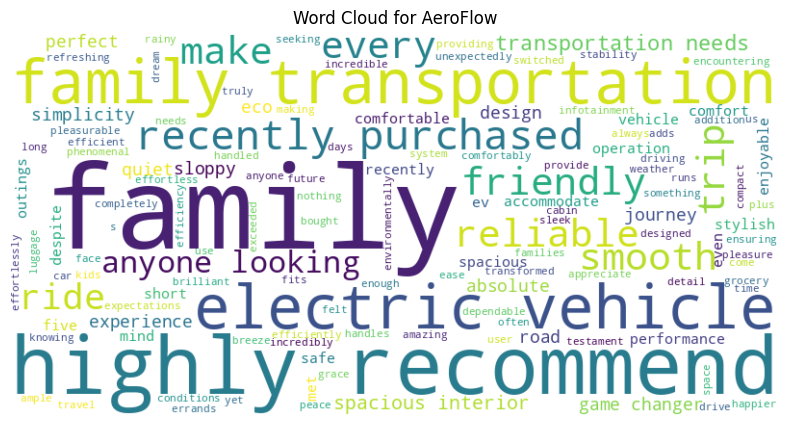

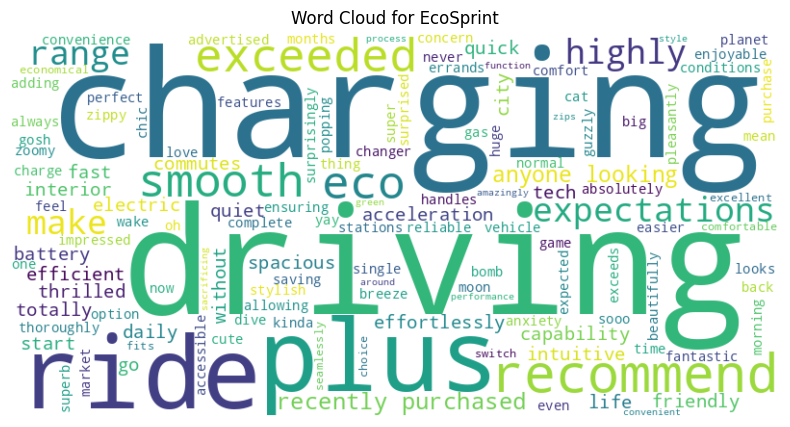

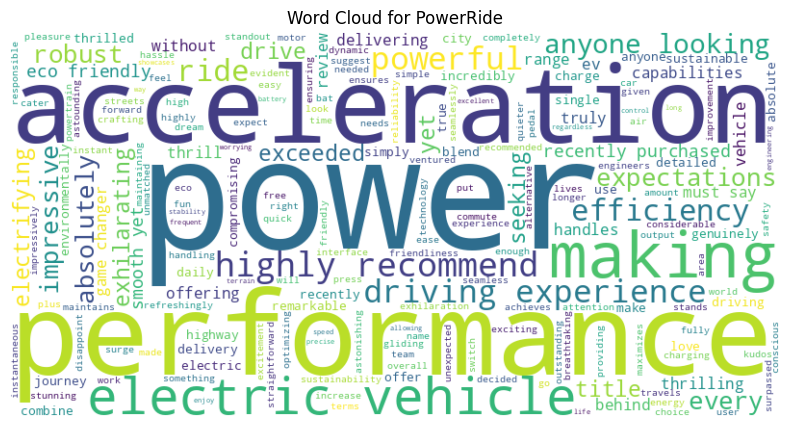

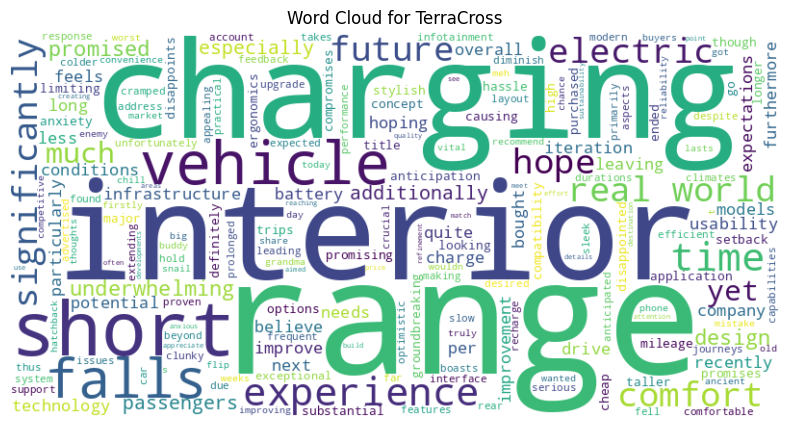

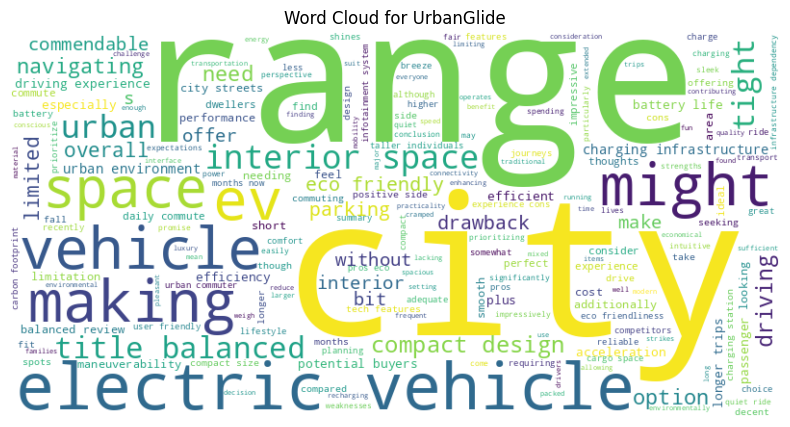

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# List of vehicle models to exclude
vehicle_models = product_reviews['VehicleModel'].unique().tolist()

# Function to preprocess and clean text
def preprocess_text(text, vehicle_models):
    # Remove vehicle model names
    for model in vehicle_models:
        text = re.sub(model, '', text, flags=re.IGNORECASE)
    return text.lower()

# Apply the preprocess function
product_reviews['CleanedReview'] = product_reviews['ReviewText'].apply(lambda x: preprocess_text(x, vehicle_models))

# Function to create a word cloud
def create_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# Aggregate reviews text by vehicle model
grouped_reviews = product_reviews.groupby('VehicleModel')['CleanedReview'].apply(' '.join)

# Create word clouds for each vehicle model, excluding the vehicle name
for model, reviews in grouped_reviews.items():
    create_word_cloud(reviews, f'Word Cloud for {model}')

## Sentiment analysis per vehicle model

In [10]:
%pip install textblob

  Using cached regex-2024.11.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:00a 0:00:01
Using cached regex-2024.11.6-cp310-cp310-macosx_11_0_arm64.whl (284 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [textblob]1/3 [nltk]
Note: you may need to restart the kernel to use updated packages.


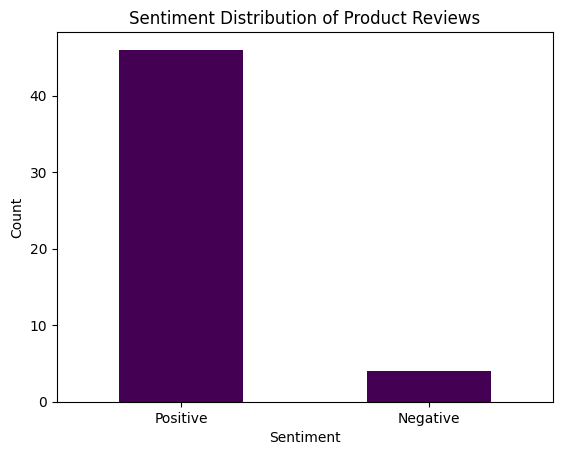

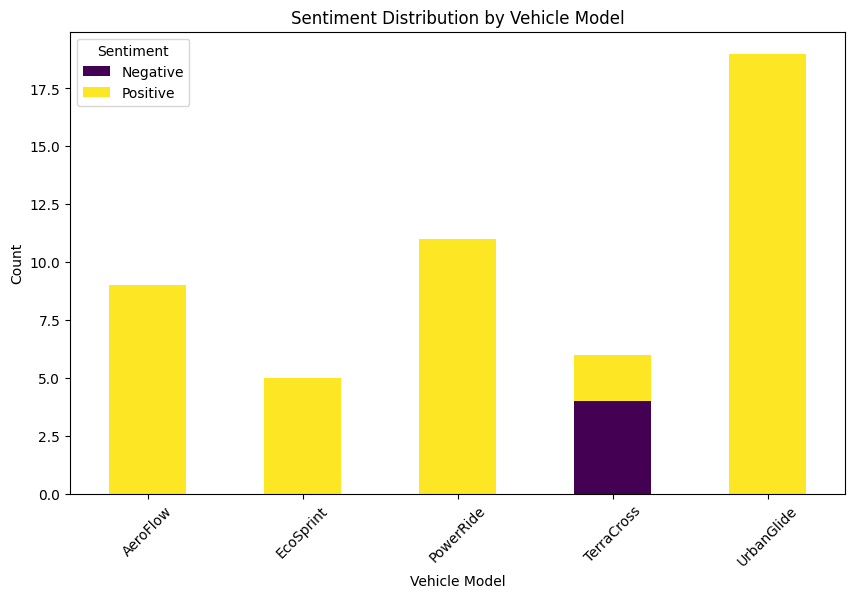

In [12]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Sentiment analysis using TexBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

product_reviews['Sentiment'] = product_reviews['ReviewText'].apply(get_sentiment)

# Distribution of sentiments
sentiment_counts = product_reviews['Sentiment'].value_counts()
sentiment_counts.plot(kind='bar', colormap= 'viridis')
plt.title('Sentiment Distribution of Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Distribution of sentiments by vehicle model
sentiment_per_model = product_reviews.groupby(['VehicleModel', 'Sentiment']).size().unstack(fill_value=0)
sentiment_per_model.plot(kind='bar', stacked=True, figsize=(10, 6), colormap= 'viridis')
plt.title('Sentiment Distribution by Vehicle Model')
plt.xlabel('Vehicle Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

## Setiment over time

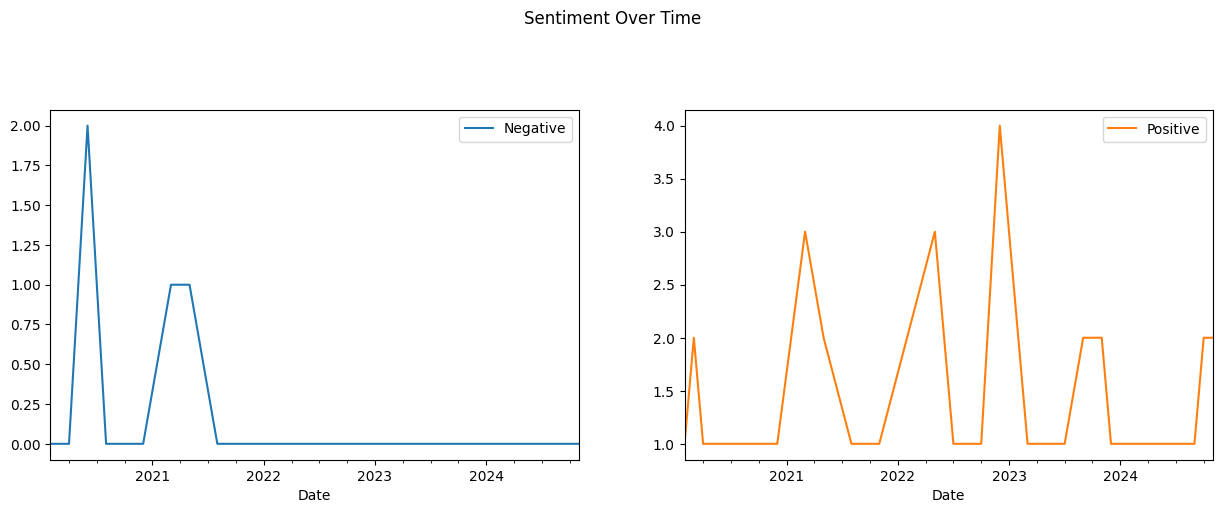

In [17]:
product_reviews['Date'] = pd.to_datetime(product_reviews['Date'])
sentiment_over_time = product_reviews.groupby(product_reviews['Date'].dt.to_period('M'))['Sentiment'].value_counts().unstack(fill_value=0)
sentiment_over_time.plot(kind='line', subplots=True, layout=(2, 2), figsize=(15, 10), title="Sentiment Over Time")
plt.show()

## Get customer_segmentation dataset from the Lakehouse
* Load `customer_segmentation` as a Pandas DataFrame
* Join `customer_segmentation` with `product_reviews` on `customer_id`

In [18]:
# Query to get all products reviews
sql = "SELECT * FROM lakehouse.gold.customer_segmentation"

# Create a Flight descriptor for the query
descriptor = flight.FlightDescriptor.for_command(sql)

# Perform the query using call_options to include headers
options = flight.FlightCallOptions(headers=headers)
flight_info = client.get_flight_info(descriptor, options)
reader = client.do_get(flight_info.endpoints[0].ticket, options)

# Convert to Pandas DataFrame
customer_segmentation = reader.read_pandas()

# Display the first few rows of the DataFrame
print(customer_segmentation.head())

   customer_id first_name                          email           city  \
0          342    Ariella      aegglestone9h@jiathis.com           Reno   
1            9      Abner           awhebell8@utexas.edu        Atlanta   
2         1264      Bevin      bjoplinz3@cyberchimps.com  New Brunswick   
3          547      Teddy  tdebernardif6@dailymail.co.uk         Eugene   
4          710      Keane             kfazanjp@bbc.co.uk         Denver   

        state        country  total_purchases  average_purchase_value  \
0      Nevada  United States                4            63907.167500   
1     Georgia  United States                2            66930.695000   
2  New Jersey  United States                1            36394.350000   
3      Oregon  United States                4            60863.942500   
4    Colorado  United States                6            65084.188333   

                               preferred_models  
0             TerraCross, EcoSprint, UrbanGlide  
1         

In [19]:
# Ensure 'customer_id' is type of integer
customer_segmentation['customer_id'] = customer_segmentation['customer_id'].astype(int)
product_reviews['CustomerID'] = product_reviews['CustomerID'].astype(int)

# Convert CustomerID to customer_id for merging
product_reviews.rename(columns={'CustomerID': 'customer_id'}, inplace=True)

# Merge the datasets on customer_id
merged_df = pd.merge(product_reviews, customer_segmentation, on='customer_id', how='left')

# Display the merged DataFrame
print(merged_df.head())

   customer_id       Date  Rating ReviewID  \
0         1966 2021-03-16       4  REV2069   
1         2331 2023-05-26       4  REV7911   
2          445 2022-10-11       5  REV4626   
3         2019 2022-07-15       4  REV1804   
4         2174 2020-09-12       5  REV1565   

                                          ReviewText VehicleModel  \
0  "We recently purchased the AeroFlow, and it's ...     AeroFlow   
1  Title: Balanced Review of the UrbanGlide EV\n\...   UrbanGlide   
2  I recently purchased the PowerRide EV, and I m...    PowerRide   
3  The UrbanGlide electric vehicle offers a sleek...   UrbanGlide   
4  I recently purchased the PowerRide, and it has...    PowerRide   

                                       CleanedReview Sentiment first_name  \
0  "we recently purchased the , and it's been ama...  Positive     Ludvig   
1  title: balanced review of the  ev\n\nhaving dr...  Positive    Umberto   
2  i recently purchased the  ev, and i must say, ...  Positive     Sandra   


## Sentiment by State

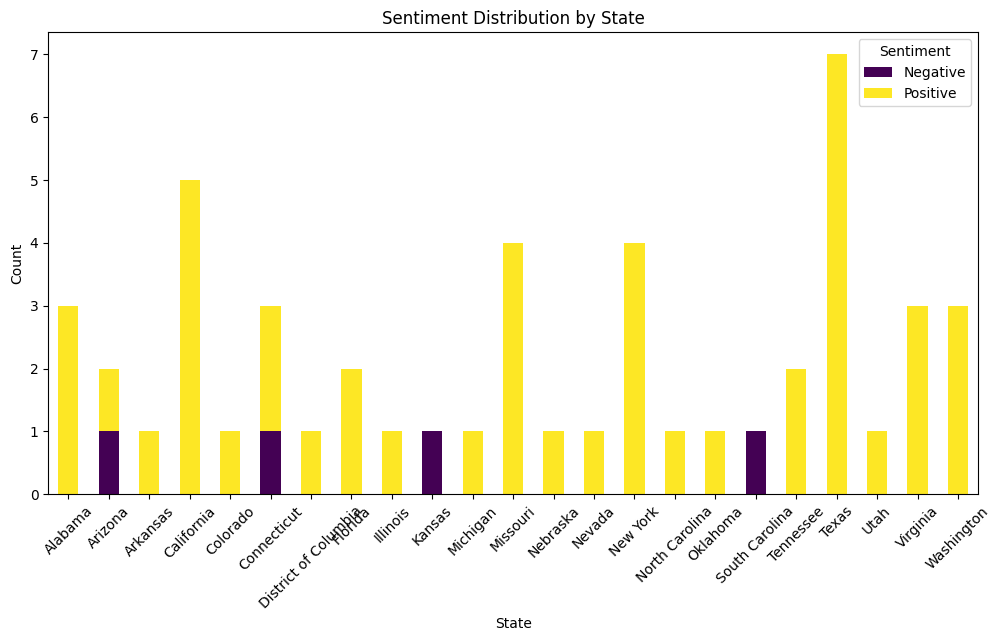

In [21]:
sentiment_by_state = merged_df.groupby('state')['Sentiment'].value_counts().unstack(fill_value=0)
sentiment_by_state.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Sentiment Distribution by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

## Sentiment by VIP status

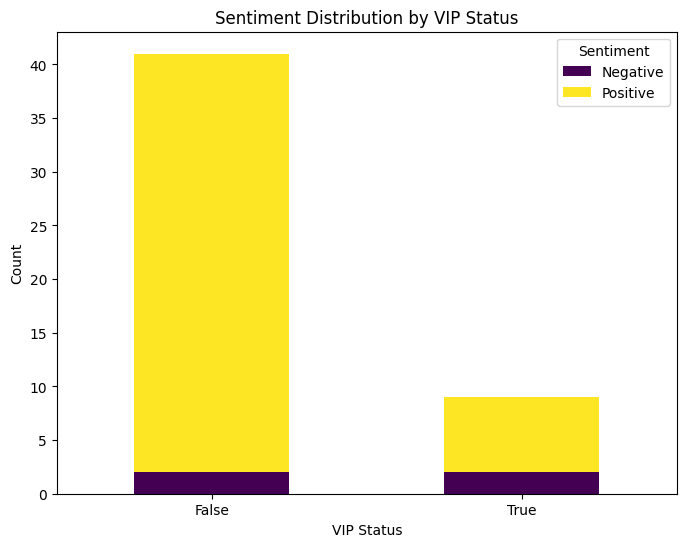

In [22]:
# Add is_vip colume based on total_purchases
merged_df['is_vip'] = merged_df['total_purchases'] > 3
sentiment_by_vip = merged_df.groupby('is_vip')['Sentiment'].value_counts().unstack(fill_value=0)
sentiment_by_vip.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
plt.title('Sentiment Distribution by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()